In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers

import re

In [2]:
from keras import backend as K

keras.utils.set_random_seed(42)

In [3]:
physical_devices = tf.config.list_physical_devices()
CLASSES = 48
IMAGE_SIZE = 24

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - black, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [5]:
def read_file(filename):
  
  with open(filename, 'r') as file:
    lines = file.readlines()
    
    # Remove newLines
    for i, line in enumerate(lines):
      lines[i] = line.replace('\n', '')
    
    # We assume these are integers
    EXAMPLES_NR = int(lines[0])
    PIXELS_NR = int(lines[1])
    
    inputs = list()
    labels = np.zeros(EXAMPLES_NR, dtype=int)
    
    examples_raw = lines[2:EXAMPLES_NR+2]
    
    for i, example_raw in enumerate(examples_raw):
      # Split by spaces (treats multiple as one)
      tokens = re.split('\s+', example_raw)
      
      pixel_values = np.array(tokens[0:PIXELS_NR])
      attributes = tokens[PIXELS_NR:]
      
      pixel_values = np.array(pixel_values, dtype=float)
      pixel_values = pixel_values.reshape([IMAGE_SIZE, IMAGE_SIZE])
      
      inputs.append(pixel_values)
      labels[i] = int(attributes[2])
      
    inputs = np.array(inputs)
  return inputs, labels

In [6]:
# classes 0-15
X_0, y_0 = read_file('./data/x24x24.txt')
# classes 16-31
X_1, y_1 = read_file('./data/y24x24.txt')
# # classes 32-48
X_2, y_2 = read_file('./data/z24x24.txt')

print(len(X_0), len(y_0))
print(len(X_1), len(y_1))
print(len(X_2), len(y_2))

2321 2321
2208 2208
2306 2306


In [7]:
from sklearn.model_selection import train_test_split

# Concatenate train and test images
X = np.concatenate((X_0, X_1, X_2))
y = np.concatenate((y_0, y_1, y_2))
print(len(X), len(y))

N_TRAIN_EXAMPLES=int(len(X) * 0.8)
N_TEST_EXAMPLES=len(X) - N_TRAIN_EXAMPLES


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES, test_size=N_TEST_EXAMPLES, random_state=1)

# One-Hot encoding
# Getting dummy variables
y_train_fixed = np.zeros((y_train.shape[0], CLASSES))
# y_valid_fixed = np.zeros((y_valid.shape[0], 10))
y_test_fixed = np.zeros((y_test.shape[0], CLASSES))

for i, value in enumerate(y_train):
  y_train_fixed[i][value] = 1
  
for i, value in enumerate(y_test):
  y_test_fixed[i][value] = 1

6835 6835


In [8]:
print(len(X_test))

1367


## Building a model

I decided to down-scale the alexNet as it was for the long time the SOTA Convolutional Neural Network Architecture

Full AlexNet implementation in keras:

```py
  keras.Input(shape=(227, 227, 3)),
  layers.Conv2D(96, kernel_size=11, strides=4, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Conv2D(256, kernel_size=5, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Conv2D(384, kernel_size=3, padding='same', activation="relu"),
  layers.Conv2D(384, kernel_size=3, padding='same', activation="relu"),
  layers.Conv2D(256, kernel_size=3, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Dropout(0.5),
  layers.Dense(4096, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(4096, activation="relu"),
  layers.Dense(CLASSES, activation="softmax")
```

In [9]:
from keras import Sequential, Input
from functools import partial

conv_regularizer = regularizers.l2(0.0006)
dense_regularizer = regularizers.l2(0.01)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_regularizer=conv_regularizer)


model = keras.Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    DefaultConv2D(96),
    layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Dropout(0.3),
    DefaultConv2D(256, kernel_size=5),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Dropout(0.4),
    DefaultConv2D(384),
    tf.keras.layers.Dropout(0.5),
    DefaultConv2D(384),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=dense_regularizer),
    tf.keras.layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 256)         0

In [10]:
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy

# optimizer = Adam(learning_rate=0.00025)
optimizer = Adam(learning_rate=0.001)

model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

## Training Preparation

In [11]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [13]:
%%time
batch_size = 200
epochs = 250

history = model.fit(
  X_train, y_train_fixed,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  # callbacks=[model_checkpoint_callback]
)

Epoch 1/250
22/22 [==============================] - 7s 133ms/step - loss: 8.1761 - accuracy: 0.0299 - val_loss: 6.1252 - val_accuracy: 0.0238
Epoch 2/250
22/22 [==============================] - 1s 36ms/step - loss: 5.1631 - accuracy: 0.0261 - val_loss: 4.4762 - val_accuracy: 0.0247
Epoch 3/250
22/22 [==============================] - 1s 36ms/step - loss: 4.1812 - accuracy: 0.0386 - val_loss: 3.9596 - val_accuracy: 0.0494
Epoch 4/250
22/22 [==============================] - 1s 36ms/step - loss: 3.8550 - accuracy: 0.0473 - val_loss: 3.7696 - val_accuracy: 0.0411
Epoch 5/250
22/22 [==============================] - 1s 35ms/step - loss: 3.7249 - accuracy: 0.0640 - val_loss: 3.6732 - val_accuracy: 0.0430
Epoch 6/250
22/22 [==============================] - 1s 32ms/step - loss: 3.5742 - accuracy: 0.0677 - val_loss: 3.4788 - val_accuracy: 0.0567
Epoch 7/250
22/22 [==============================] - 1s 33ms/step - loss: 3.4637 - accuracy: 0.0766 - val_loss: 3.3724 - val_accuracy: 0.0941
Epoch

In [14]:
# model.load_weights("models/checkpoints/famous48_test_model_v2_best.keras")
model.evaluate(X_test, y_test_fixed)

43/43 [==============================] - 1s 9ms/step - loss: 1.1375 - accuracy: 0.7996


[1.1374937295913696, 0.799561083316803]

In [22]:
length = len(history.history['accuracy'])
print("train set accuracy:", round(history.history['accuracy'][length-1], 3))
print("train loss:", round(history.history['loss'][length-1], 3))
print("validation set accuracy:", round(history.history['val_accuracy'][length-1], 3))
print("validation set loss:", round(history.history['val_loss'][length-1], 3))

train set accuracy: 0.896
train loss: 0.775
validation set accuracy: 0.81
validation set loss: 1.115


In [23]:
results = model.evaluate(X_test, y_test_fixed)
print("test set accuracy:", round(results[1], 3))
print("test set loss:", round(results[0], 3))

43/43 [==============================] - 1s 5ms/step - loss: 1.1375 - accuracy: 0.7996
test set accuracy: 0.8
test set loss: 1.137


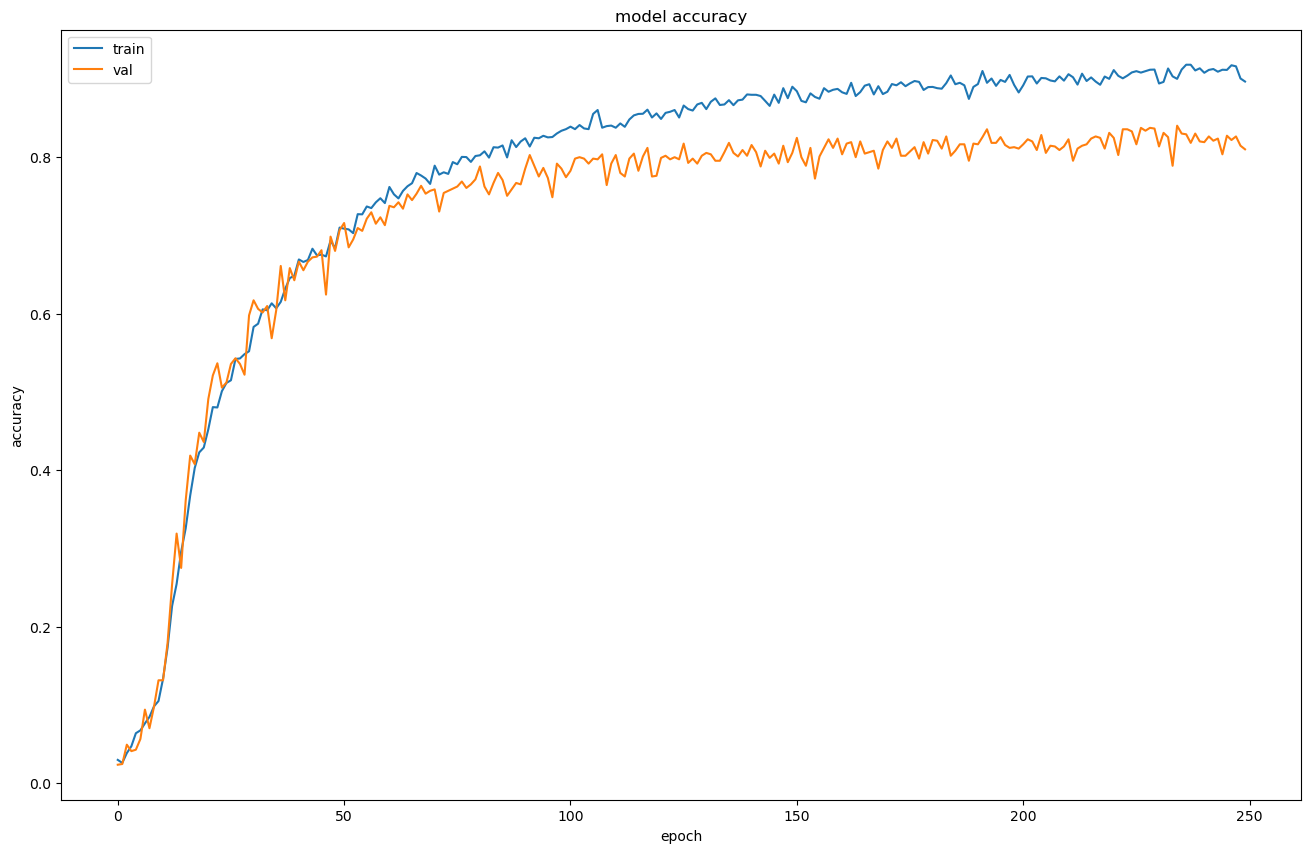

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()